# Fig2 results - invitro dataset of a cell line mix

Here we show the analysis of the in-vitro pools containing various ratios of HL60, SUDHL4, K562, and THP1 human leukemic cells, analyzed by standard bulk RNA sequencing. The reference dataset is pool of the same cell lines, sequenced through 10x 3' technology. The ground truth for cell line proportions are pre-determined ratios that were added in the tubes after cell counting. We then use this ground truth to compare the predictive value of CLIMB and a panel of bulk deconvolution methods: BayesPrism [16], CiberSortX [17], TAPE [18], Scaden [19], MUSIC [20], BisqueRNA [21], and NNLS [20], using random proportions as a negative control. 

In [2]:
library(ggplot2) ; library(glmnet) ; library(Biobase)
library(reshape2) ; library(ggpubr); library(SingleCellExperiment)
library(ComplexHeatmap) ; library(circlize) ; library(RColorBrewer)
library(cocor) ; library(ggpmisc)

# load Deconvolution Methods
library(MuSiC) ; library(ClimbTheCliff) ; library(BayesPrism)

### Functions 

In [3]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){ return( sign(cor(pr,tr)) * cor(pr,tr)^2 ) }
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    # per row metrics:
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    # per-column metrics:
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    # overall metrics:
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){
    SStot = sum((tr - mean(tr))^2)
    SSres = sum((pr - tr)^2)
    return(1 - SSres / SStot)
}
r_square <- function(pr, tr){
    return( sign(cor(pr,tr))*cor(pr,tr)^2 )
}
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
} 
### Function for each deconvolution methods ### 
deconvolution_climb <- function(sc, bulks, true_prop, celltype_names){
    climb_res = climb(sc, bulks)
    climb_prop = climb_res$props.corrected
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_bayesprism <- function(sc, bulks, true_prop, celltype_names){
    myPrism <- new.prism(reference= t(exprs(sc)), 
                         mixture=t(exprs(bulks)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc$cellType), 
                         cell.state.labels = as.character(sc$cellType), 
                         key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
    bp.res <- run.prism(prism = myPrism, n.cores=6)
    bayesprism_prop <- get.fraction (bp=bp.res, which.theta="final",
             state.or.type="type")
    bayesprism_prop = add_missing_celltypes(bayesprism_prop, celltype_names)
    return(as.matrix(bayesprism_prop[,celltype_names]))
}
deconvolution_music <- function(sc, bulks, true_prop, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    music_prop = music.output$Est.prop.weighted
    music_prop = add_missing_celltypes(music_prop, celltype_names)
    return(music_prop[,celltype_names])
}
deconvolution_nnls <- function(sc, bulks, true_prop, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    nnls_prop = music.output$Est.prop.allgene
    nnls_prop = add_missing_celltypes(nnls_prop, celltype_names)
    return(nnls_prop[,celltype_names])
}
deconvolution_bisque <- function(sc, bulks, true_prop, celltype_names){
    bisque.out = BisqueRNA::ReferenceBasedDecomposition(bulks, sc, use.overlap=F)
    bisque_prop = t(bisque.out$bulk.props)
    bisque_prop = add_missing_celltypes(bisque_prop, celltype_names)
    return(bisque_prop[,celltype_names])
}
deconvolution_random <- function(nnls_prop){
    nnls_prop = read.csv(paste0(out_dir, '/nnls_prop.csv'), row.names='X')
    set.seed(1)
    rand_prop = nnls_prop[sample(rownames(nnls_prop)), sample(colnames(nnls_prop))]
    rownames(rand_prop) = rownames(nnls_prop) ; colnames(rand_prop) = colnames(nnls_prop)
    return(rand_prop)
}
write_tables_cibersortx <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    sc_mat = exprs(sc)
    colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    write.table(sc_mat , paste0(tab_dir,"/TMP_cibersortx_sc_mat.txt"), sep = '\t', quote=F)
    write.table(exprs(bulks), paste0(tab_dir,"/TMP_cibersortx_pbulks.txt"), sep = '\t', quote=F)
    # Reformulate to add 'Gene' at the start of the file
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_pbulks.txt > ', 
    #              tab_dir, '/cibersortx_pbulks.txt'))
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_sc_mat.txt > ', 
    #              tab_dir, '/cibersortx_sc_mat.txt'))
    # remove temp files
    #system(paste0('rm ',tab_dir, '/TMP_*'))
}
write_tables_tape_scaden <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # Write all input tables formatted for TAPE / Scaden
    write.csv(t(exprs(bulks)), paste0(tab_dir, "/tape_scaden_bulks_expr.csv"), quote=F)
    sc_mat_TAPE = exprs(sc)
    sc_mat_TAPE = t(sc_mat_TAPE)
    rownames(sc_mat_TAPE) = sc$cellType
    write.csv(sc_mat_TAPE, paste0(tab_dir, "/tape_scaden_scmat_expr.csv"), quote=F)
}
deconvolution_scaden <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING: launching TAPE / Scaden from the command line induces figures popping up
    # which blocks the process (figures have to be closed manually). 
    # To prevent these figures to be made, one can comment lines 103-109,115-119,128-131, 
    # and 172-176 in the file 'tape_scaden_env/lib/python3.7/site-packages/TAPE/utils.py'
    message('Launch Scaden / TAPE deconvolution')
    # Launch bash script that will launch environment and python script
    system(paste0('bash launch_TAPE_and_Scaden.sh ', tab_dir, '/tape_scaden_scmat_expr.csv ',
                  tab_dir, '/tape_scaden_bulks_expr.csv ',
                  'data/GeneLength.txt ',
                  tab_dir, '/'), wait=TRUE)
}
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    true_p = read.csv(paste0(odir, '/true_prop.csv'), row.names='X')
    sample_names = row.names(true_p)
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop_corrected.csv'), row.names='X')[,as.character(celltype_names)]
    #climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')[,as.character(celltype_names)]
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')[,as.character(celltype_names)]
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')[,as.character(celltype_names)]
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')[,as.character(celltype_names)]
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')[,as.character(celltype_names)]
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')[,as.character(celltype_names)]
    tape_p = load_tape_prop(tdir, odir, celltype_names)[,as.character(celltype_names)]
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)[,as.character(celltype_names)]
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='Mixture')[,as.character(celltype_names)]
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_prop) ; true_prop_rows = rownames(true_prop)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}                                                                                           
make_all_metrics <- function(all_ps, t_prop){
    all_rs = list()
    for(p in 1:length(all_ps)){
        name_p = names(all_ps)[p]
        all_rs[[name_p]] = suppressWarnings(comp_rows_and_cols(all_ps[[p]], t_prop))
    }
    names(all_rs) = names(all_ps)
    return(all_rs)
}
launch_all_deconvolution_methods <- function(sc, bulks, true_prop, celltype_names, out_dir){ 
    # Create folders
    message('Creating folders')
    tmp_dir = paste0(out_dir, '/tmp_tabs')
    dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)
    write.csv(true_prop, paste0(out_dir, '/true_prop.csv'), quote=F)
    write.csv(celltype_names, paste0(out_dir, '/celltype_names.csv'), quote=F)

    ### CLIMB deconvolution ###
    message('CLIMB deconvolution')
    climb_prop = deconvolution_climb(sc, bulks, true_prop, celltype_names)
    write.csv(climb_prop, paste0(out_dir, '/climb_prop.csv'), quote=F)
    message(paste0('CLIMB Accruacy as PCC: ', cor(flatten(true_prop), flatten(climb_prop))))

    ### BayesPrism deconvolution ###
    message('BayesPrism deconvolution')
    bayesprism_prop = deconvolution_bayesprism(sc, bulks, true_prop, celltype_names)
    write.csv(bayesprism_prop, paste0(out_dir, '/bayesprism_prop.csv'), quote=F)
    message(paste0('BayesPrism Accruacy as PCC: ', cor(flatten(true_prop), flatten(bayesprism_prop))))
    
    ### MUSIC deconvolution ###
    message('MUSIC deconvolution')
    music_ps = deconvolution_music(sc, bulks, true_prop, celltype_names)
    write.csv(music_ps, paste0(out_dir, '/music_prop.csv'), quote=F)
    message(paste0('MuSiC Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(music_ps)))))
    
    ### NNLS deconvolution ### 
    message('NNLS deconvolution')
    nnls_prop = deconvolution_nnls(sc, bulks, true_prop, celltype_names)
    write.csv(nnls_prop, paste0(out_dir, '/nnls_prop.csv'), quote=F)
    message(paste0('NNLS Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(nnls_prop)))))
    
    ### BisqueRNA deconvolution ### 
    message('BisqueRNA deconvolution')
    bisque_prop = deconvolution_bisque(sc, bulks, true_prop, celltype_names)
    write.csv(bisque_prop, paste0(out_dir, '/bisque_prop.csv'), quote=F)
    message(paste0('BisqueRNA Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(bisque_prop)))))

    ### Deconvolution Scaden / TAPE 
    message('TAPE / Scaden deconvolution')
    write_tables_tape_scaden(sc, bulks, true_prop, celltype_names, tmp_dir)
    deconvolution_scaden(sc, bulks, true_prop, celltype_names, tmp_dir)
    tape_prop = load_tape_prop(tmp_dir, out_dir, celltype_names)
    scaden_prop = load_scaden_prop(tmp_dir, out_dir, celltype_names)
    message(paste0('TAPE prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(tape_prop)))))
    message(paste0('Scaden prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(scaden_prop)))))

    ### Random proportions deconvolution ### 
    message('Random deconvolution')
    rand_prop = deconvolution_random(nnls_prop)
    write.csv(rand_prop, paste0(out_dir, '/rand_prop.csv'), quote=F)
    message(paste0('Random prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(rand_prop)))))
    
    ### CiberSortX deconvolution ### 
    message('Writing tables for CiberSortX')
    write_tables_cibersortx(sc, bulks, true_prop, celltype_names, tmp_dir)
}                                                                                          

### Load data

We load the data stored as `ExpressionSet` object. We will load the scRNA-seq reference dataset in the object `sc.es` and the bulk RNA-seq from six mixtures in `bulk.es`. 

In [4]:
# Load ExpressionSet object containing scRNA-seq data from in-vitro cell mixes
sc.es = readRDS("data/invitro_experiment/invitro_sc_es.RDS")
sc.es$cellType = factor(sc.es$cellType)
dim(sc.es)

Features  Samples 
    6169     2342

2342 cells were sequenced and 6169 genes kept after filtering variable genes with Scran::ModelGeneVar

In [5]:
# Load ExpressionSet object containing bulk RNA-seq data from in-vitro cell mixes
bulk.es = readRDS("data/invitro_experiment/invitro_bulk_es.RDS")
dim(bulk.es)

Features  Samples 
    6169        6

6 mixtures of cell lines with expression from the same panel of 6169 genes

In [6]:
# Load True cell line proportions (based on the volume of homogeneised cells pippeted in the mixture)
true_prop = as.matrix(pData(bulk.es))
true_prop

,HL60,K562,SUDHL4,THP1
BULK1,0.2600,0.0900,0.3300,0.3200
BULK2,0.5700,0.1100,0.0700,0.2500
BULK3,0.3333,0.2222,0.0000,0.4444
BULK4,0.0500,0.0400,0.6100,0.3000
BULK5,0.0198,0.3168,0.1881,0.4752
BULK6,0.1200,0.2600,0.2000,0.4200


In [7]:
celltype_names = levels(sc.es$cellType)
celltype_names

[1] "HL60"   "K562"   "SUDHL4" "THP1"

### CLIMB deconvolution of bulk samples
Here we launch CLIMB deconvolution with default settings to predict cell type abundance

In [8]:
climb_out = climb(sc.es, bulk.es, mode='abundance')
climb_prop = climb_out$props.corrected
climb_prop = climb_prop[,colnames(true_prop)]

ABUNDANCE mode: predicting cell-type proportions in bulks

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

First pass of cell-type abundance prediction done. Start second pass...

Second pass is done. Cell-type abundance prediction is over.



In [9]:
# Recover all metrics from multiple angles
climb.res = comp_rows_and_cols(climb_prop, true_prop)

In [10]:
# median pearson correlation per samples (6 values)
# From the run:
print(median(unlist(climb.res[1])))
print(climb.res[1])

[1] 0.9701314
[[1]]
[1] 0.9036623 0.9990747 0.9769821 0.9717616 0.9685013 0.7718523



No id variables; using all as measure variables

No id variables; using all as measure variables



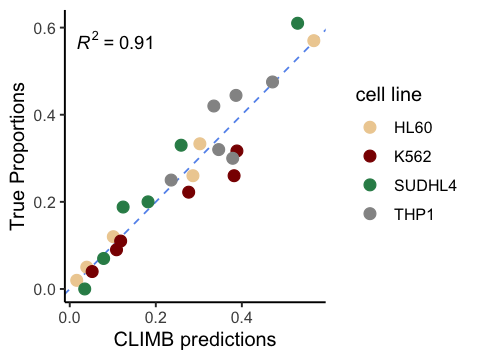

In [12]:
# Plot and display the results 
options(repr.plot.width=4, repr.plot.height=3)
df_cor = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(climb_prop)))
colnames(df_cor) = c('cell line', 'True Proportions', 'x', 'CLIMB predictions')
g = ggplot(df_cor) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=`True Proportions`, x=`CLIMB predictions`, colour=`cell line`), size=3) + theme_classic2() + 
    stat_cor(method = "pearson", aes(y=`True Proportions`, x=`CLIMB predictions`, label = after_stat(rr.label))) +
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('CLIMB predictions')
#pdf('results/fig2/climb_scatter.pdf', width=4, height=3) ; g ; dev.off()
g

## Fig. 2B

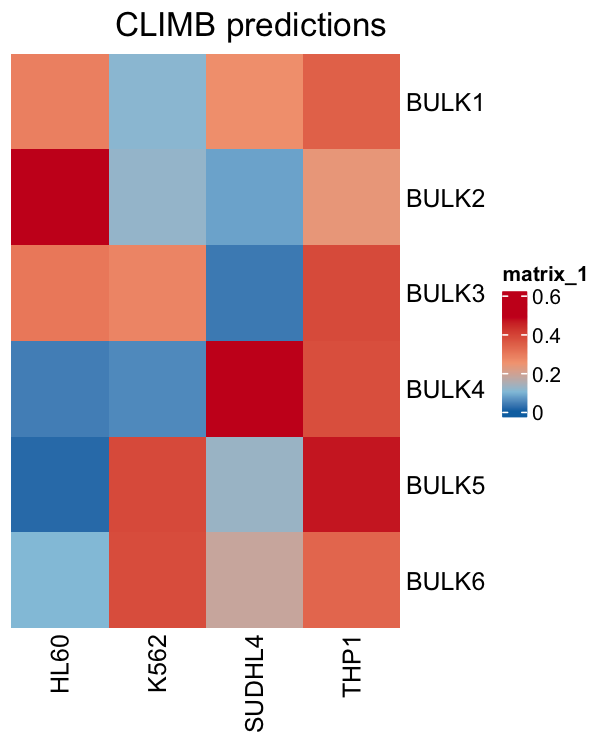

In [13]:
rownames(climb_prop) = rownames(true_prop)
options(repr.plot.width=4, repr.plot.height=5, repr.plot.res=150)
col_fun = colorRamp2(c(0, 0.1, 0.25, 0.5), rev(brewer.pal(4,"RdBu"))) # we use the same color breaks for both heatmap
h_climb <- Heatmap(climb_prop, col=col_fun, cluster_rows = F, cluster_columns = F, show_row_dend = F, show_column_dend = F)
d_climb = draw(h_climb, column_title="CLIMB predictions", column_title_gp=grid::gpar(fontsize=16))
#pdf('results/fig2/climb_prediction_heatmap.pdf', width=4, height=5) ; d_climb ; dev.off()
d_climb

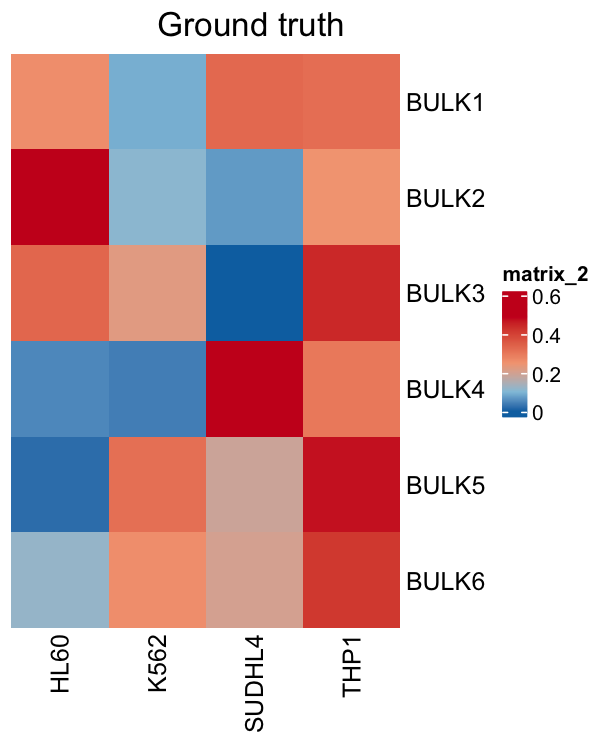

In [14]:
options(repr.plot.width=4, repr.plot.height=5, repr.plot.res=150)
h_true <- Heatmap(true_prop, col=col_fun, cluster_rows = F,  cluster_columns = F, show_row_dend = F, show_column_dend = F)
d_true = draw(h_true, column_title="Ground truth", column_title_gp=grid::gpar(fontsize=16))
#pdf('results/fig2/true_prop_heatmap.pdf', width=4, height=5) ; d_true ; dev.off()
d_true

### Launch all deconvolution methods

Here we launch our panel of deconvolution methods. This step can be skipped if one wants to load directly pre-computed proportions for all methods.

Requirements: MuSiC, BayesPrism, BisqueRNA, CLIMB packages needs to be installed in R. The environment for TAPE and Scaden should have been set up. The R script will then call `launch_tape_scaden.sh`, a bash script that will activate `tape-scaden-env` environment, and then launch a python script called `launch_tape_scaden.py`. The resulting tables are then loaded in R. 

For CiberSortX, this script simply writes tables which are the input for CSX. They need to be post-processed by adding the string `Gene` followed by a tab at the beginning of the file, which can be done with the following bash commands:

`cat <(echo -ne "Gene\t") TMP_cibersortx_pbulks.txt > cibersortx_pbulks.txt`

`cat <(echo -ne "Gene\t") TMP_cibersortx_sc_mat.txt > cibersortx_sc_mat.txt`

### Launch all Deconvolution methods  

The following function will launch all deconvolution method and takes around one hour to run. Alternatively, all pre-processing results can be loaded at the next step, which will launch CLIMB deconvolution.

__Warning: This needs to have the environment 'tape_scaden_env' setup and accessible on the root of the folder. See README.md for setting up the environment. Also, upon Scaden run figures will pop up and needs to be closed for Scaden to run, otherwise it freezes... (It's possible de change Scaden source code to avoid this, see README.md)__

In [15]:
out_dir = 'data/invitro_experiment/tables/'
# to re-run all deconvolution methods from scratch, uncomment the following line:
# Otherwise, deconvolution results are loaded from saved tables on the next cell
#launch_all_deconvolution_methods(sc = sc.es, bulks = bulk.es, true_prop = true_prop,
#                                 celltype_names = celltype_names, out_dir=out_dir)

### Load pre-processed Deconvolution results

Here is the results of diverse deconvolution methods, to be loaded to reproduce same results as in the manuscripts, and to be compared with results obtained by CLIMB which we will run below. 

NNLS proportions for certain cell lines have columns constituted of zero only. These returns the warning message 'the standard deviation is zero'.

In [62]:
all_props = load_all_props(out_dir, include_cibersortx = T)
all_props$CLIMB = climb_prop
all_res = make_all_metrics(all_props, true_prop)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



## BayesPrism Deconvolution

We provide here the code used to run BayesPrism and reproduce results. Unfortunately we did not manage to install it on Renku, thus we will rely on pre-computed cell-type proportions.

In [18]:
bayesprism_prop = all_props$BayesPrism
median(all_res$BayesPrism[[1]])

[1] 0.7902794

No id variables; using all as measure variables

No id variables; using all as measure variables



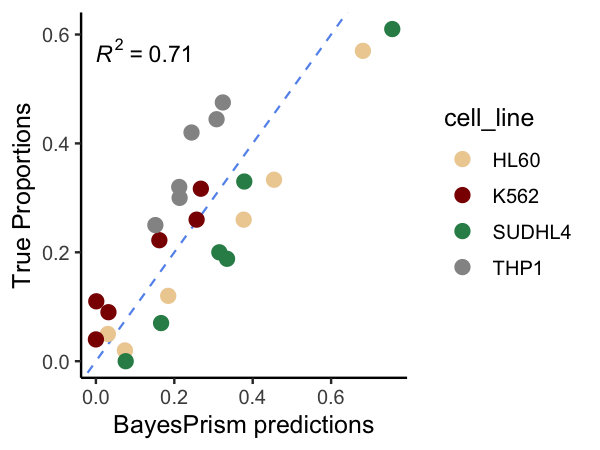

In [26]:
options(repr.plot.width=4, repr.plot.height=3)
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(bayesprism_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'bayesprism_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(x=bayesprism_prop, y=true.prop, colour=cell_line), size=3) + theme_classic2() + 
    stat_cor(method = "pearson", aes(x=bayesprism_prop, y=true.prop, label = after_stat(rr.label))) +
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('BayesPrism predictions')  
#pdf('results/fig2/bayesprism_scatter.pdf', width=4, height=3) ; g ; dev.off()
g

## MuSiC Deconvolution

We will run here MuSiC deconvolution, which is also used to derive NNLS predictions.

In [22]:
music_prop = all_props$MuSiC
median(all_res$MuSiC[[1]])

[1] 0.7285475

No id variables; using all as measure variables

No id variables; using all as measure variables



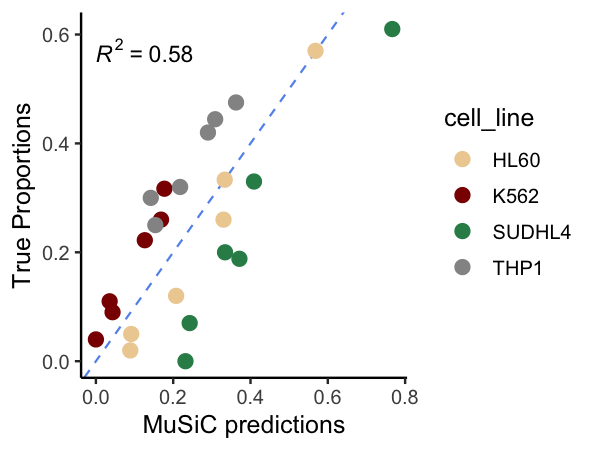

In [27]:
options(repr.plot.width=4, repr.plot.height=3)
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(music_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'music_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(x=music_prop, y=true.prop, colour=cell_line), size=3) + theme_classic2() + 
    stat_cor(method = "pearson", aes(x=music_prop, y=true.prop, label = after_stat(rr.label))) +
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('MuSiC predictions') 
#pdf('results/fig2/scatter_music.pdf', width=4, height=3) ; g ; dev.off()
g

## NNLS 

NNLS shows very bad correlation. Is it a problem with the MuSiC implementation ?

In [24]:
nnls_prop = all_props$NNLS
median(all_res$NNLS[[1]])

[1] -0.23796

No id variables; using all as measure variables



No id variables; using all as measure variables



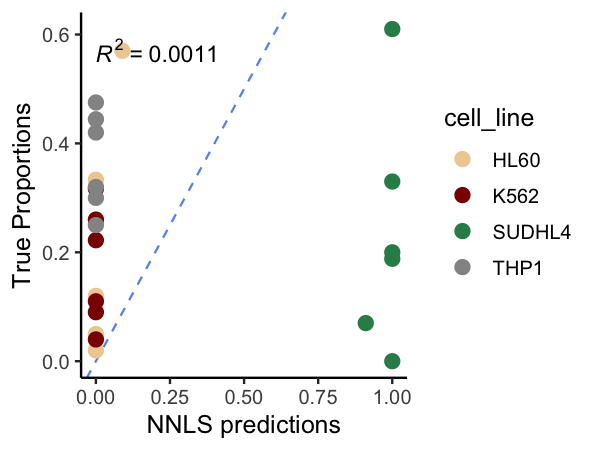

In [28]:
# Draw MuSiC predictons against true proportions
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(nnls_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'nnls_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true.prop, x=nnls_prop, colour=cell_line), size=3) + theme_classic2() + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    stat_cor(method = "pearson", aes(x=nnls_prop, y=true.prop, label = after_stat(rr.label))) +
    ylab('True Proportions') + xlab('NNLS predictions') 
#pdf('results/fig2/scatter_nnls.pdf', width=6, height=5) ; g ; dev.off()
g

## Re-implement NNLS

Here we re-implement ourself NNLS using 'nnls' R package, and building the signature matrix with simple average expression per cell type

In [29]:
sign_mat = aggregate(t(exprs(sc.es)), list(sc.es$cellType), mean)
rownames(sign_mat) = sign_mat$`Group.1`
sign_mat = sign_mat[,-1]
sign_mat = t(sign_mat)[,colnames(true_prop)]

In [30]:
nnls_props_ = list()
for(i in 1:6){
    nnls_props_[[i]] = nnls(sign_mat, exprs(bulk.es)[,i])$x
}
nnls_prop_ = do.call(rbind,nnls_props_)
nnls_prop_ = nnls_prop_ / rowSums(nnls_prop_) # normalize coefficients

In [31]:
print(paste0('correlation with MuSiC-derived NNLS: ',cor(as.vector(nnls_prop_), as.vector(nnls_prop))))
print(paste0('correlation with true proportions:   ',cor(as.vector(nnls_prop_), as.vector(true_prop))))

[1] "correlation with MuSiC-derived NNLS: 0.999990083402501"
[1] "correlation with true proportions:   -0.0314205426633778"


NNLS seems indeed to perform very bad in that situation no matter how we implement it

## CiberSortX Deconvolution 

As CSX was run on the CSX website, we directly load the ouput. CSX was ran with all default settings.

In [32]:
csx_prop = all_props$CiberSortX
median(all_res$CiberSortX[[1]])

[1] 0.6868062

No id variables; using all as measure variables

No id variables; using all as measure variables



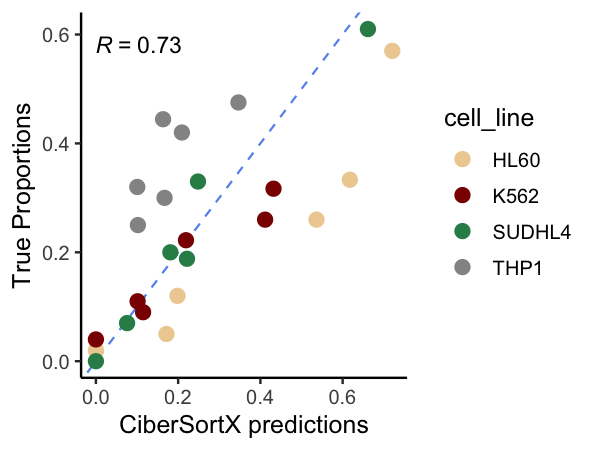

In [33]:
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(csx_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'csx_props')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true.prop, x=csx_props, colour=cell_line), size=3) + theme_classic2() + 
    stat_cor(method = "pearson", aes(x=csx_props, y=true.prop, label = after_stat(r.label))) +
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('CiberSortX predictions')
#pdf('results/fig2/scatter_cibersortx.pdf', width=4, height=3) ; g ; dev.off()
g

## TAPE method 

TAPE is a python method that can be run through another notebook `rev_TAP_launch.ipynb`. The package is not working on Renku but TAPE/Scaden methods can both be installed and ran through our notebook for reproducing results.

In [63]:
tape_prop = all_props$TAPE
median(all_res$TAPE[[1]])

[1] 0.5818814

## Scaden method

Scaden method can be ran through the same notebook as TAPE and relies on the same input matrices.

In [64]:
scaden_prop = all_props$Scaden
median(all_res$Scaden[[1]])

[1] 0.9722838

No id variables; using all as measure variables

No id variables; using all as measure variables



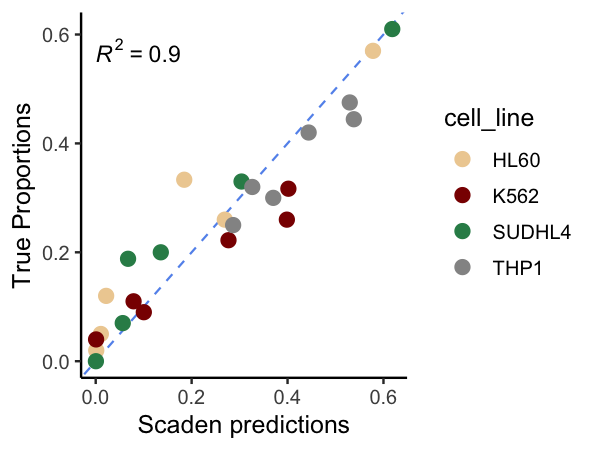

In [65]:
options(repr.plot.width=4, repr.plot.height=3)
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(scaden_prop)))
colnames(df_msc) = c('cell_line', 'true_prop', 'x', 'scaden_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true_prop, x=scaden_prop, colour=cell_line), size=3) + theme_classic2() +              
    stat_cor(method = "pearson", aes(x=scaden_prop, y=true_prop, label = after_stat(rr.label))) +
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('Scaden predictions') 
#pdf('results/fig2/scatter_scaden.pdf', width=4, height=3) ; g ; dev.off()
g

Of note: Scaden have variability in its output / accuracy between different runs

## Make statistics to compare correlation / errors 

### First we compare correlation using package 'cocor'

In [66]:
df_props = data.frame(true=as.vector(as.matrix(true_prop)), scaden=as.vector(as.matrix(all_props$Scaden)), 
                      tape=as.vector(as.matrix(all_props$TAPE)), climb=as.vector(as.matrix(all_props$CLIMB)),
                      csx=as.vector(as.matrix(all_props$CiberSortX)), bayesprism=as.vector(as.matrix(all_props$BayesPrism)),
                      music=as.vector(as.matrix(all_props$MuSiC)), nnls=as.vector(as.matrix(all_props$NNLS)),
                      random=as.vector(as.matrix(all_props$Random)), bisque=as.vector(as.matrix(all_props$BisqueRNA)))

In [67]:
# Run Cocor package to compare CLIMB correlation against ground truth versus other method's correlations
cocor_res.scaden =     cocor(~true + climb | true + scaden, df_props, alternative='greater')
cocor_res.tape =       cocor(~true + climb | true + tape, df_props, alternative='greater')
cocor_res.csx =        cocor(~true + climb | true + csx, df_props, alternative='greater')
cocor_res.bayesprism = cocor(~true + climb | true + bayesprism, df_props, alternative='greater')
cocor_res.music =      cocor(~true + climb | true + music, df_props, alternative='greater')
cocor_res.nnls =       cocor(~true + climb | true + nnls, df_props, alternative='greater')
cocor_res.bisque =     cocor(~true + climb | true + bisque, df_props, alternative='greater')
cocor_res.random =     cocor(~true + climb | true + random, df_props, alternative='greater')

In [68]:
df_signif = data.frame(pvalue=c(cocor_res.scaden@pearson1898$p.value, cocor_res.tape@pearson1898$p.value, 
                    cocor_res.csx@pearson1898$p.value, cocor_res.bayesprism@pearson1898$p.value,
                    cocor_res.music@pearson1898$p.value, cocor_res.nnls@pearson1898$p.value,
                    cocor_res.bisque@pearson1898$p.value, cocor_res.random@pearson1898$p.value),
           comparison=c('CLIMB_vs_Scaden', 'CLIMB_vs_TAPE', 'CLIMB_vs_CiberSortX', 'CLIMB_vs_BayesPrism',
                        'CLIMB_vs_MUSIC', 'CLIMB_vs_NNLS', 'CLIMB_vs_BisqueRNA', 'CLIMB_vs_Random'))
df_signif$signif = 'n.s'
df_signif$signif[df_signif$pvalue < 0.05] <- '*'
df_signif$signif[df_signif$pvalue < 0.01] <- '**'
df_signif$signif[df_signif$pvalue < 0.001] <- '***'
df_signif$signif[df_signif$pvalue < 0.0001] <- '****'

In [69]:
# Show results in a table: 
df_signif[rev(order(df_signif$pvalue)),]

,pvalue,comparison,signif
,<dbl>,<chr>,<chr>
1,3.731526e-01,CLIMB_vs_Scaden,n.s
4,2.147250e-02,CLIMB_vs_BayesPrism,*
5,9.029191e-03,CLIMB_vs_MUSIC,**
3,6.124431e-03,CLIMB_vs_CiberSortX,**
2,2.269402e-03,CLIMB_vs_TAPE,**
7,3.402014e-06,CLIMB_vs_BisqueRNA,****
6,9.432526e-07,CLIMB_vs_NNLS,****
8,9.289824e-11,CLIMB_vs_Random,****


In [70]:
# Run Cocor package to compare CLIMB coreelation against ground truth versus other method's correlations
rmse.ttest.scaden =    t.test(all_res$CLIMB[[4]], all_res$Scaden[[4]])$p.val
rmse.ttest.tape =       t.test(all_res$CLIMB[[4]], all_res$TAPE[[4]])$p.val
rmse.ttest.csx =        t.test(all_res$CLIMB[[4]], all_res$CiberSortX[[4]])$p.val
rmse.ttest.bayesprism = t.test(all_res$CLIMB[[4]], all_res$BayesPrism[[4]])$p.val
rmse.ttest.music =      t.test(all_res$CLIMB[[4]], all_res$MuSiC[[4]])$p.val
rmse.ttest.nnls =       t.test(all_res$CLIMB[[4]], all_res$NNLS[[4]])$p.val
rmse.ttest.bisque =     t.test(all_res$CLIMB[[4]], all_res$BisqueRNA[[4]])$p.val
rmse.ttest.random =     t.test(all_res$CLIMB[[4]], all_res$Random[[4]])$p.val

In [71]:
df_signif = data.frame(pvalue=c(rmse.ttest.scaden, rmse.ttest.tape, 
                    rmse.ttest.csx, rmse.ttest.bayesprism,
                    rmse.ttest.music, rmse.ttest.nnls,
                    rmse.ttest.bisque, rmse.ttest.random),
           comparison=c('CLIMB_vs_Scaden', 'CLIMB_vs_TAPE', 'CLIMB_vs_CiberSortX', 'CLIMB_vs_BayesPrism',
                        'CLIMB_vs_MUSIC', 'CLIMB_vs_NNLS', 'CLIMB_vs_BisqueRNA', 'CLIMB_vs_Random'))
df_signif$signif = 'n.s'
df_signif$signif[df_signif$pvalue < 0.05] <- '*'
df_signif$signif[df_signif$pvalue < 0.01] <- '**'
df_signif$signif[df_signif$pvalue < 0.001] <- '***'
df_signif$signif[df_signif$pvalue < 0.0001] <- '****'

In [72]:
df_signif

pvalue,comparison,signif
<dbl>,<chr>,<chr>
4.930515e-01,CLIMB_vs_Scaden,n.s
3.302882e-03,CLIMB_vs_TAPE,**
3.973090e-03,CLIMB_vs_CiberSortX,**
7.765316e-04,CLIMB_vs_BayesPrism,***
3.489740e-04,CLIMB_vs_MUSIC,***
2.783833e-04,CLIMB_vs_NNLS,***
1.549243e-03,CLIMB_vs_BisqueRNA,**
5.879360e-06,CLIMB_vs_Random,****


## Plot the comparative results 

Use only per-sample metrics 

In [73]:
# Change the Metric by setting type.err to 1, 2, 3, or 4
generate_comp_plot <- function(type.err=1){
    #type.err , 1=pcor, 2=scor, 3=r_square, 4=rmse
    type.err.l = list('PCC', 'SCC', 'R2', 'RMSE')
    methods = c('MuSiC', 'NNLS', 'CLIMB', 'TAPE', 'Scaden', 'Bisque', 'Random', 'BayesPrism', 'CiberSortX')
    df_scor = data.frame(cbind(all_res$MuSiC[[type.err]], all_res$NNLS[[type.err]], 
                               all_res$CLIMB[[type.err]], all_res$TAPE[[type.err]], all_res$Scaden[[type.err]],
                               all_res$BisqueRNA[[type.err]], all_res$Random[[type.err]], all_res$BayesPrism[[type.err]], 
                               all_res$CiberSortX[[type.err]]))
    colnames(df_scor) = methods
    levels_ = colnames(df_scor)[rev(order(colMedians(as.matrix(df_scor), na.rm = T)))]
    if(type.err.l[[type.err]] == 'RMSE'){levels_ = rev(levels_)}
    df_scor_m = reshape2::melt(df_scor)
    df_scor_m$variable = factor(df_scor_m$variable, levels = levels_) 
    g_rows = ggplot(df_scor_m) + geom_boxplot(aes(x=variable, y=value, color=variable), outlier.shape = NA) + theme_classic() +
                geom_jitter(aes(x=variable, y=value, color=variable)) + theme_classic() +
                scale_color_manual(values=ifelse(grepl('CLIMB', levels_), 'darkred', 'grey38')) + 
                theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
                xlab('') + ylab(type.err.l[type.err]) #+ coord_flip() # ylab(expression(pa
    return(g_rows)
}

# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse 
g_pcc = generate_comp_plot(type.err=1) # PCC
g_scc = generate_comp_plot(type.err=2) # SCC
g_r2 = generate_comp_plot(type.err=3) # R-square
g_rmse = generate_comp_plot(type.err=4) # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



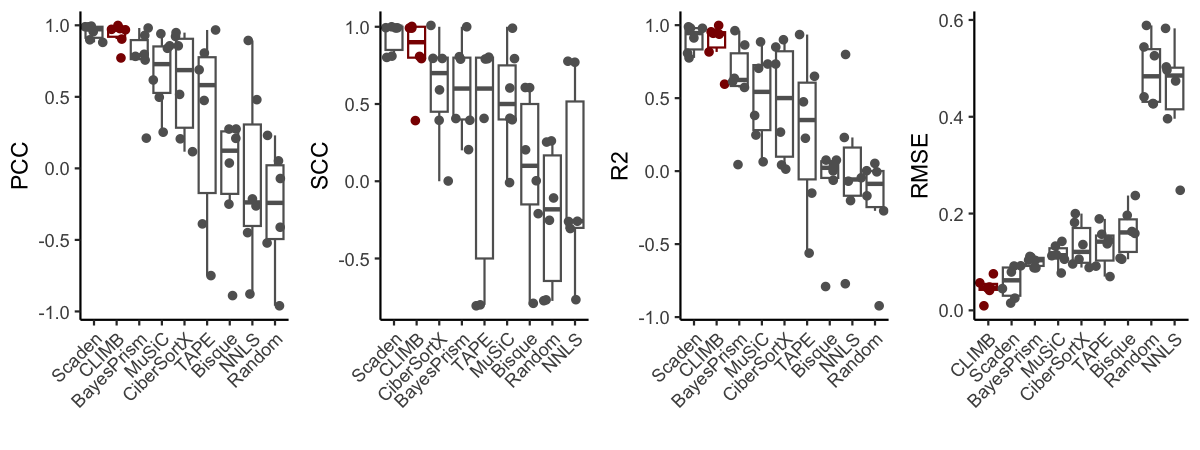

In [74]:
options(repr.plot.width=8, repr.plot.height=3)
g_arr = ggarrange(g_pcc, g_scc, g_r2, g_rmse, ncol = 4, nrow = 1)
#pdf('results/fig2/comparative_boxplots.pdf', width=8, height=3) ; g_arr ; dev.off()
g_arr

## Ranking method according to 4 metrics

We rank deconvolution methods according to the median values of the "bulk level" comparison. Each bulk sample get four accuracy metrics: PCC, SCC, RMSE, and R-square, and deconvolution methods are ranked according to their median values.

In [75]:
all_rmse_cl = c(median(all_res$Random[[4]]), median(all_res$TAPE[[4]]), median(all_res$NNLS[[4]]), median(all_res$BisqueRNA[[4]]),
             median(all_res$MuSiC[[4]]), median(all_res$Scaden[[4]]), median(all_res$BayesPrism[[4]]),
             median(all_res$CiberSortX[[4]]), median(all_res$CLIMB[[4]]))
all_pcc_cl = c(median(all_res$Random[[1]]), median(all_res$TAPE[[1]]), median(all_res$NNLS[[1]]), median(all_res$BisqueRNA[[1]]),
             median(all_res$MuSiC[[1]]), median(all_res$Scaden[[1]]), median(all_res$BayesPrism[[1]]),
             median(all_res$CiberSortX[[1]]), median(all_res$CLIMB[[1]]))
all_scc_cl = c(median(all_res$Random[[2]]), median(all_res$TAPE[[2]]), median(all_res$NNLS[[2]]), median(all_res$BisqueRNA[[2]]),
             median(all_res$MuSiC[[2]]), median(all_res$Scaden[[2]]), median(all_res$BayesPrism[[2]]),
             median(all_res$CiberSortX[[2]]), median(all_res$CLIMB[[2]]))
all_r2_cl = c(median(all_res$Random[[3]]), median(all_res$TAPE[[3]]), median(all_res$NNLS[[3]]), median(all_res$BisqueRNA[[3]]),
             median(all_res$MuSiC[[3]]), median(all_res$Scaden[[3]]), median(all_res$BayesPrism[[3]]),
             median(all_res$CiberSortX[[3]]), median(all_res$CLIMB[[3]]))

In [76]:
df = data.frame(rank_rmse_cl=rank(all_rmse_cl),rank_pcc_cl=rank(-1*all_pcc_cl),
                rank_scc_cl=rank(-1*all_scc_cl), rank_r2_cl=rank(-1*all_r2_cl))

In [77]:
df$mean_rank = rowMeans(as.matrix(df))
df$sd_rank = rowSds(as.matrix(df))
rownames(df) = c('Random', 'TAPE', 'NNLS', 'BisqueRNA', 'MuSiC', 'Scaden', 'BayesPrism', 'CiberSortX', 'CLIMB')
df$method = rownames(df)
df$method = factor(df$method, levels=rev(df$method[order(df$mean_rank)]))

In [78]:
# Show results in a table : 
df

,rank_rmse_cl,rank_pcc_cl,rank_scc_cl,rank_r2_cl,mean_rank,sd_rank,method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Random,8,9,8.0,9,8.500,0.5000000,Random
TAPE,6,6,4.5,6,5.625,0.6495191,TAPE
NNLS,9,8,9.0,8,8.500,0.5000000,NNLS
BisqueRNA,7,7,7.0,7,7.000,0.0000000,BisqueRNA
MuSiC,4,4,6.0,4,4.500,0.8660254,MuSiC
Scaden,2,1,1.0,1,1.250,0.4330127,Scaden
BayesPrism,3,3,4.5,3,3.375,0.6495191,BayesPrism
CiberSortX,5,5,3.0,5,4.500,0.8660254,CiberSortX
CLIMB,1,2,2.0,2,1.750,0.4330127,CLIMB


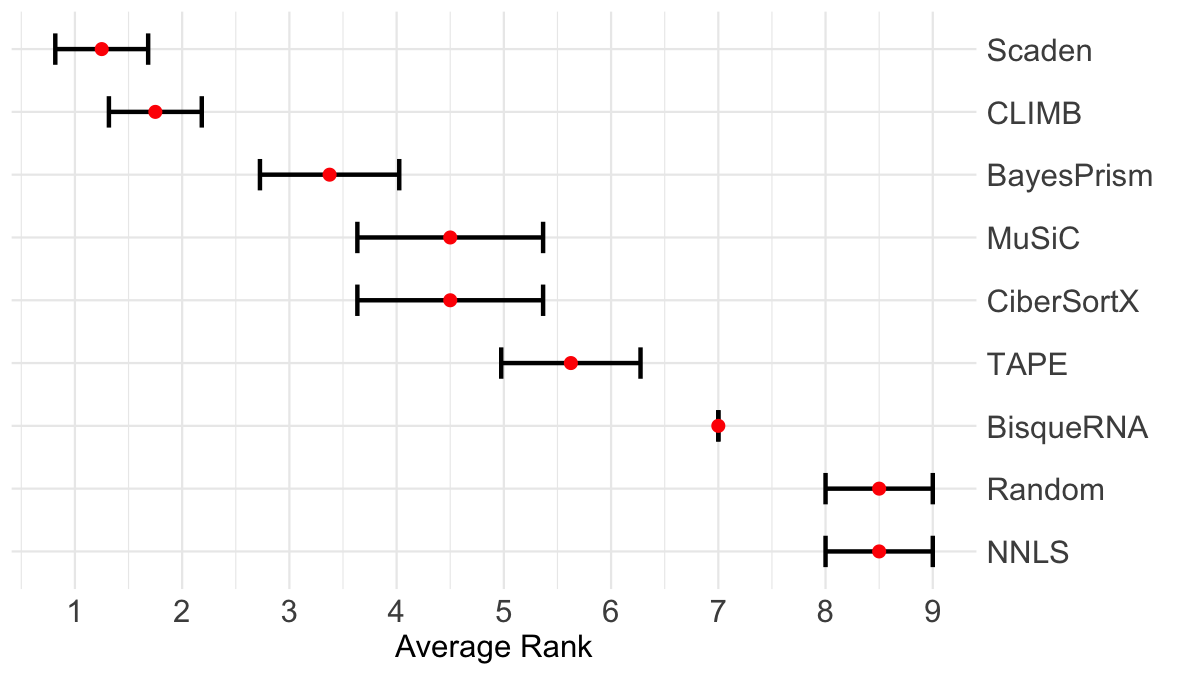

In [79]:
options(repr.plot.width=8, repr.plot.height=4.5)
g <- ggplot() + geom_errorbar(data=df, aes(y=method, xmin=mean_rank-sd_rank, xmax=mean_rank+sd_rank), width=0.5, size=1, color="black") +
    geom_point(data=df, aes(x=mean_rank, y=method), size=2.5, color='red') + scale_x_continuous(breaks=1:9) + 
    theme_minimal() + theme(axis.text=element_text(size = 15), text=element_text(size = 15)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "right")
#pdf('results/fig2/comparative_rankings.pdf', width=8, height=4.5) ; g ; dev.off()
g

In [80]:
df_wilcox = data.frame(pvalue=c(wilcox.test(num(df['CLIMB',1:4]), num(df['Scaden',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['BayesPrism',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['MuSiC',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['CiberSortX',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['TAPE',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['Random',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['BisqueRNA',1:4]), exact = FALSE)$p.value,
                                wilcox.test(num(df['CLIMB',1:4]), num(df['NNLS',1:4]), exact = FALSE)$p.value),
                       comparison=c('CLIMB_vs_Scaden',  'CLIMB_vs_BayesPrism', 'CLIMB_vs_MUSIC', 'CLIMB_vs_CiberSortX','CLIMB_vs_TAPE', 
                          'CLIMB_vs_Random','CLIMB_vs_BisqueRNA', 'CLIMB_vs_NNLS'))
df_wilcox$signif = 'n.s'
df_wilcox$signif[df_wilcox$pvalue < 0.05] <- '*'
df_wilcox$signif[df_wilcox$pvalue < 0.01] <- '**'
df_wilcox$signif[df_wilcox$pvalue < 0.001] <- '***'
df_wilcox$signif[df_wilcox$pvalue < 0.0001] <- '****'
df_wilcox

pvalue,comparison,signif
<dbl>,<chr>,<chr>
0.24706153,CLIMB_vs_Scaden,n.s
0.02283622,CLIMB_vs_BayesPrism,*
0.02283622,CLIMB_vs_MUSIC,*
0.02283622,CLIMB_vs_CiberSortX,*
0.02283622,CLIMB_vs_TAPE,*
0.02465329,CLIMB_vs_Random,*
0.01770607,CLIMB_vs_BisqueRNA,*
0.02465329,CLIMB_vs_NNLS,*


every p-values are now comprise between 0.01 and 0.05. Because we restricted our analysis to the comparison "per sample" only, we have less data points (ranks) to compare. The comparison of CLIMB vs Scaden now became significant.